<a href="https://colab.research.google.com/github/abhishekshingadiya/ML-cabinet/blob/main/EmoGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.preprocessing import image as k_image
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import cv2
from keras import optimizers
import time
import imageio
import PIL
from IPython import display
latent_dim  = 100
height = 64
width = 64
channels = 3
depth = 64
image_dir = './yemoji/*.png'
save_dir = './emoji_output'

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def remove_transparency(source, background_color):
    """
    Converts image from 4-channel image with transparency to a
    3-channel image of specified background color.
    """

    source_img = source[:, :, :3]
    source_mask = source[:, :, 3] * (1 / 255.0)
    source_mask = np.repeat(source_mask[:, :, np.newaxis], 3, axis=2)

    background_mask = 1.0 - source_mask

    bg_part = (background_color * (1 / 255.0)) * (background_mask)
    source_part = (source_img * (1 / 255.0)) * (source_mask)

    return np.uint8(cv2.addWeighted(bg_part, 255.0, source_part, 255.0, 0.0))


def get_images(image_dir, height=64, width=64):
    """
    Compile all images into a single array of
    dimensions (n x width x height x 3).
    """

    image_list = glob.glob(image_dir)
    images = []
    for image_path in image_list:
        img = cv2.imread(image_path, -1)

        if img.shape[2] == 4:
            img = remove_transparency(img, 255)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (height, width))

        images.append(img)

    images = np.asarray(images) / 255.
    return images


In [2]:


def build_discriminator(
        height=64, width=64, channels=3, depth=64, lr=0.0001, dropout=0.3,
        decay=1e-8):
    """
    Builds discriminator model. The discriminator takes a candidate image
    as input and classifies it into two classes: generated or real. Adjust
    learning rate and dropout rate to tune performance.
    """

    model = tf.keras.Sequential()

    model.add(layers.Conv2D(depth * 1, kernel_size=4,
                            input_shape=(height, width, channels), padding="same"))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(depth * 1, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(depth * 1, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(depth * 2, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(depth * 4, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D(depth * 8, kernel_size=4, strides=2, padding="same"))
    model.add(layers.LeakyReLU())

    model.add(layers.Dropout(dropout))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    # model.add(layers.Dense(1, activation='sigmoid'))

    # model_optimizer = tf.keras.optimizers.RMSprop(
    #     lr=lr,
    #     decay=decay,
    #     clipvalue=1.0)

    # model.compile(optimizer=model_optimizer, loss='binary_crossentropy')
    return model




In [3]:

def build_generator(
        height=64, width=64, channels=3, depth=64, dropout=0.3):
    """
    Builds generator model. Converts a latent space vector into a candidate
    image. Kernel density of conv2DTranspose layers is set to a multiple of
    stride length to avoid checkerboard artifacts in generated images. Adjust
    learning rate (in GAN model) and dropout rate to tune performance. Note
    that the generator model is not compiled in this function.
    """
    model = tf.keras.Sequential()
    model.add(layers.Dense(4 * 4 * depth * 8, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((4, 4, depth * 8)))
    assert model.output_shape == (None, 4, 4, depth * 8)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(depth * 8, kernel_size=4,
                                  strides=2, padding='same'))
    assert model.output_shape == (None, 8,8,depth * 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(depth * 4, kernel_size=4,
                                  strides=2, padding='same'))
    assert model.output_shape == (None, 16,16,depth * 4)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(depth * 2, kernel_size=4,
                                  strides=2, padding='same'))
    assert model.output_shape == (None, 32,32,depth * 2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(depth, kernel_size=4,
                                  strides=2, padding='same'))
    assert model.output_shape == (None, 64,64,depth )
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(channels, kernel_size=7, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model



In [4]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [5]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [6]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
generator=build_generator()
discriminator=build_discriminator()

In [8]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [9]:
EPOCHS = 10000
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE=32
BUFFER_SIZE=100
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [10]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [11]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go


    # Save the model every 15 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      display.clear_output(wait=True)
      generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [12]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [13]:
# !unzip ./yemojiV2.zip
# import os
# os.listdir('./yemoji')

In [14]:
train_images = get_images(image_dir)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

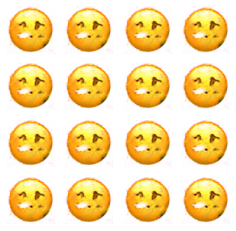

In [16]:
train(train_dataset, EPOCHS)

In [17]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [18]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [19]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [20]:
!zip -r /content/emoji_output.zip /content/emoji_output

	zip warning: name not matched: /content/emoji_output

zip error: Nothing to do! (try: zip -r /content/emoji_output.zip . -i /content/emoji_output)
